# Projet MACH/DataViz/BDA

### Loading data

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.master("local[*]").appName("accidents").config("spark.driver.memory", "6g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

data = spark.read.csv(f"US_Accidents_March23.csv", header=True, inferSchema=True)
data.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

### Data Exploration

In [3]:
data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [4]:
print("Nombre de lignes :", data.count())

Nombre de lignes : 7728394


In [8]:
from pyspark.sql.functions import col, sum

print("Nombre de valeurs manquantes par colonne:")
# data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

null_df = data.select(
    [
        sum(col(c).isNull().cast("int")).alias(c)
        for c in data.columns
    ]
)

rows = null_df.collect()
counts = {
    c: rows[0][i+1] for i, c in enumerate(data.columns[1:])
}

counts_df = spark.createDataFrame([(k, v) for k, v in counts.items()], ["Column name", "Null Count"])
counts_df.orderBy("Null Count", ascending=False).show(23)

Nombre de valeurs manquantes par colonne:


+--------------------+----------+
|         Column name|Null Count|
+--------------------+----------+
|             End_Lat|   3402762|
|             End_Lng|   3402762|
|   Precipitation(in)|   2203586|
|       Wind_Chill(F)|   1999019|
|     Wind_Speed(mph)|    571233|
|      Visibility(mi)|    177098|
|      Wind_Direction|    175206|
|         Humidity(%)|    174144|
|   Weather_Condition|    173459|
|      Temperature(F)|    163853|
|        Pressure(in)|    140679|
|   Weather_Timestamp|    120228|
|      Sunrise_Sunset|     23246|
|      Civil_Twilight|     23246|
|   Nautical_Twilight|     23246|
|Astronomical_Twil...|     23246|
|        Airport_Code|     22635|
|              Street|     10869|
|            Timezone|      7808|
|             Zipcode|      1915|
|                City|       253|
|         Description|         5|
|             Station|         0|
+--------------------+----------+
only showing top 23 rows



In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

missing_values = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).collect()[0].asDict()
missing_values_df = pd.DataFrame(missing_values.items(), columns=["Column", "Missing Values"]).sort_values(by="Missing Values", ascending=False)

chart = alt.Chart(missing_values_df, title="Valeurs manquantes par colonne").mark_bar().encode(
    x=alt.X("Column", title="Colonnes", sort=None),
    y=alt.Y("Missing Values", title="Nombre de valeurs manquantes"),
).properties(width=800, height=400)

chart

/usr/lib/python3/dist-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [96]:
cities = data.select("City").distinct().collect()
print(f"Nombre de villes distintes: {len(cities)}")

Nombre de villes distintes: 13679


In [97]:
from pyspark.sql.functions import round

cities_accidents = data.groupBy("City").count().orderBy("count", ascending=False)
cities_accidents = cities_accidents.withColumn("Percentage (in %)", round((col("count") / data.count()) * 100, 2))
cities_accidents.show(20)
cities_accidents_pd = cities_accidents.limit(20).toPandas()


chart = alt.Chart(cities_accidents_pd, title="Top 20 des villes avec le plus d'accidents").mark_bar().encode(
    x=alt.X("City", title="Villes", sort=None),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart

+-------------+------+-----------------+
|         City| count|Percentage (in %)|
+-------------+------+-----------------+
|        Miami|186917|             2.42|
|      Houston|169609|             2.19|
|  Los Angeles|156491|             2.02|
|    Charlotte|138652|             1.79|
|       Dallas|130939|             1.69|
|      Orlando|109733|             1.42|
|       Austin| 97359|             1.26|
|      Raleigh| 86079|             1.11|
|    Nashville| 72930|             0.94|
|  Baton Rouge| 71588|             0.93|
|      Atlanta| 68186|             0.88|
|   Sacramento| 66264|             0.86|
|    San Diego| 55504|             0.72|
|      Phoenix| 53974|              0.7|
|  Minneapolis| 51488|             0.67|
|     Richmond| 48845|             0.63|
|Oklahoma City| 46092|              0.6|
| Jacksonville| 42447|             0.55|
|       Tucson| 39304|             0.51|
|     Columbia| 38178|             0.49|
+-------------+------+-----------------+
only showing top

/usr/lib/python3/dist-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [98]:
from pyspark.sql.functions import mean, max, min

cities_accidents.select(min("count"), max("count"), mean("count")).show()

+----------+----------+-----------------+
|min(count)|max(count)|       avg(count)|
+----------+----------+-----------------+
|         1|    186917|564.9823817530521|
+----------+----------+-----------------+



In [99]:
cities_with_many_accidents = cities_accidents.filter(col("count") >= 1000)
cities_with_little_accidents = cities_accidents.filter(col("count") < 1000)
print(f"Nombre de villes avec plus de 1000 accidents : {cities_with_many_accidents.count()}, c'est-à-dire {cities_with_many_accidents.count() / cities_accidents.count() * 100:.2f}% du nombre total de villes")
print(f"Nombre de villes avec moins de 1000 accidents : {cities_with_little_accidents.count()}, c'est-à-dire {cities_with_little_accidents.count() / cities_accidents.count() * 100:.2f}% du nombre total de villes")

Nombre de villes avec plus de 1000 accidents : 1218, c'est-à-dire 8.90% du nombre total de villes


Nombre de villes avec moins de 1000 accidents : 12461, c'est-à-dire 91.10% du nombre total de villes


In [ ]:
start_time = data.select("Start_Time").orderBy("Start_Time").toPandas()
end_time = data.select("End_Time").orderBy("End_Time").toPandas()

In [127]:
start_time_hour = pd.DataFrame(start_time["Start_Time"].dt.hour.value_counts().sort_index()).reset_index()
end_time_hour = pd.DataFrame(end_time["End_Time"].dt.hour.value_counts().sort_index()).reset_index()
start_time_hour

chart1 = alt.Chart(start_time_hour, title="Nombre d'accidents par heure de début").mark_bar(width=20).encode(
    x=alt.X("Start_Time", title="Heure de début"),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=700, height=400)
chart2 = alt.Chart(end_time_hour, title="Nombre d'accidents par heure de fin").mark_bar(width=20).encode(
    x=alt.X("End_Time", title="Heure de fin"),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=700, height=400)

chart1 | chart2

alt.HConcatChart(...)

In [122]:
start_time_day_of_week = pd.DataFrame(start_time["Start_Time"].dt.day_of_week.value_counts().sort_index()).reset_index()
start_time_day_of_week['Start_Time'] = start_time_day_of_week['Start_Time'].map({
    0: 'Lundi', 
    1: 'Mardi', 
    2: 'Mercredi', 
    3: 'Jeudi', 
    4: 'Vendredi', 
    5: 'Samedi', 
    6: 'Dimanche'
})
start_time_month = pd.DataFrame(start_time["Start_Time"].dt.month.value_counts().sort_index()).reset_index()
start_time_month['Start_Time'] = start_time_month['Start_Time'].map({
    1: 'Janvier', 
    2: 'Février', 
    3: 'Mars', 
    4: 'Avril', 
    5: 'Mai', 
    6: 'Juin', 
    7: 'Juillet', 
    8: 'Août', 
    9: 'Septembre', 
    10: 'Octobre', 
    11: 'Novembre', 
    12: 'Décembre'
})

start_time_year = pd.DataFrame(start_time["Start_Time"].dt.year.value_counts().sort_index()).reset_index()
start_time_year['Start_Time'] = start_time_year['Start_Time'].astype(str)

chart1 = alt.Chart(start_time_day_of_week, title="Nombre d'accidents par jour de la semaine").mark_bar(width=100).encode(
    x=alt.X("Start_Time", title="Jour de la semaine", sort=["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart2 = alt.Chart(start_time_month, title="Nombre d'accidents par mois").mark_bar(width=50).encode(
    x=alt.X("Start_Time", title="Mois", sort=["Janvier", "Février", "Mars", "Avril", "Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart3 = alt.Chart(start_time_year, title="Nombre d'accidents par année").mark_bar().encode(
    x=alt.X("Start_Time", title="Année"),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart1 & chart2 & chart3

/usr/lib/python3/dist-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/lib/python3/dist-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/lib/python3/dist-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

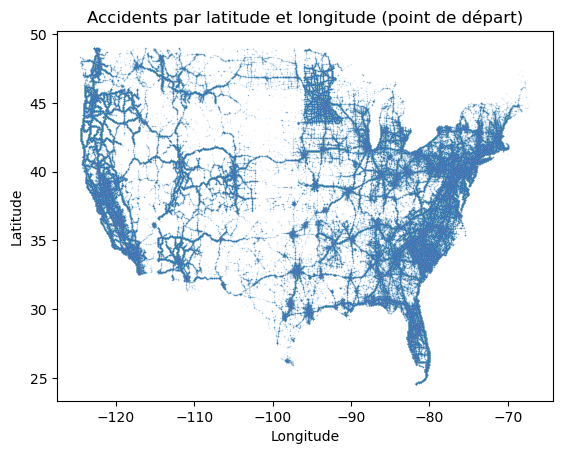

In [128]:
start_lat = data.select("Start_Lat").dropna().toPandas()
start_lon = data.select("Start_Lng").dropna().toPandas()
start_lat_lon = pd.DataFrame({
    "Start_Lat": start_lat["Start_Lat"],
    "Start_Lng": start_lon["Start_Lng"]
})

import seaborn as sns
sns.scatterplot(data=start_lat_lon, x="Start_Lng", y="Start_Lat", alpha=0.1, s=1)
plt.title("Accidents par latitude et longitude (point de départ)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [132]:
severity_counts = data.groupBy("Severity").count().orderBy("Severity")
severity_counts_pd = severity_counts.toPandas()
chart = alt.Chart(severity_counts_pd, title="Nombre d'accidents par sévérité").mark_bar(width=100).encode(
    x=alt.X("Severity", title="Sévérité",),
    y=alt.Y("count", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart

alt.Chart(...)

In [133]:
distance = data.select(mean("Distance(mi)"), max("Distance(mi)"), min("Distance(mi)")).collect()[0]
print(f"Distance moyenne : {distance[0]:.2f} miles, distance maximale : {distance[1]:.2f} miles, distance minimale : {distance[2]:.2f} miles")

Distance moyenne : 0.56 miles, distance maximale : 441.75 miles, distance minimale : 0.00 miles


In [ ]:
distance_df = data.select("Distance(mi)").dropna().toPandas()
distance_df["Distance(mi)"] = distance_df["Distance(mi)"].astype(float)

distance_df = distance_df.reset_index()
distance_df

chart = alt.Chart(distance_df, title="Distribution des distances des accidents").mark_bar().encode(
    x=alt.X("Distance(mi)", bin=alt.Bin(maxbins=50), title="Distance (miles)"),
    y=alt.Y("index", title="Nombre d'accidents"),
).properties(width=800, height=400)
chart

SchemaValidationError: `MarkDef` has no parameter named 'bin'

Existing parameter names are:
type                      filled          strokeDash             
align                     font            strokeDashOffset       
angle                     fontSize        strokeJoin             
aria                      fontStyle       strokeMiterLimit       
ariaRole                  fontWeight      strokeOffset           
ariaRoleDescription       height          strokeOpacity          
aspect                    href            strokeWidth            
bandSize                  innerRadius     style                  
baseline                  interpolate     tension                
binSpacing                invalid         text                   
blend                     limit           theta                  
clip                      line            theta2                 
color                     lineBreak       theta2Offset           
continuousBandSize        lineHeight      thetaOffset            
cornerRadius              opacity         thickness              
cornerRadiusBottomLeft    order           timeUnitBandPosition   
cornerRadiusBottomRight   orient          timeUnitBandSize       
cornerRadiusEnd           outerRadius     tooltip                
cornerRadiusTopLeft       padAngle        url                    
cornerRadiusTopRight      point           width                  
cursor                    radius          x                      
description               radius2         x2                     
dir                       radius2Offset   x2Offset               
discreteBandSize          radiusOffset    xOffset                
dx                        shape           y                      
dy                        size            y2                     
ellipsis                  smooth          y2Offset               
fill                      stroke          yOffset                
fillOpacity               strokeCap                              

See the help for `MarkDef` to read the full description of these parameters